<h1 align="center"><font size="8"> scVelo Analysis </font></h1>

> Huitian (Yolanda) Diao, Sept. 14 2020 <br>
> Source: [Velocyto notebook](https://github.com/velocyto-team/velocyto-notebooks.git)


- vlm object:
    - Gene IDs: vlm.ra['Gene']
    - Cell IDs: vlm.ca['CellID']

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import copy
import sys
from importlib import reload
from pathlib import Path

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2020-10-17 15:23.


In [2]:
code_dir = os.getcwd()
base_dir = code_dir.replace("/codes_local","")
parent_dir = "/".join(base_dir.split("/")[:-1])
tools_dir = parent_dir + "/tools"

sys.path.insert(1, tools_dir)
import sc_addons
reload(sc_addons)

sp_name = base_dir.split("/")[-1]
analysis_name = ["0", "resampledNoDyn"]

wk_dir = base_dir + "/2_scVelo/%s_scVelo_out_%s"%(analysis_name[0],analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name, analysis_name)

0_Acute-Chronic ['0', 'resampled_noDyn']


## 0. Read Velocyto Loom file

In [3]:
loom_file = base_dir + "/2_scVelo/Velocyto_run10x/Exp391.loom"
adata = scv.read(loom_file, cache=True)
adata.var_names_make_unique()

# show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


Abundance of ['spliced', 'unspliced']: [0.72 0.28]


AnnData object with n_obs × n_vars = 18353 × 22630
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

### 0.1 Preliminary filtering & data merging

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=10)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=15000) # original n_top_genes: 5000
scv.pp.log1p(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=15000) # original min_shared_counts:30, n_top_genes: 5000

Filtered out 12269 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Filtered out 1318 genes that are detected 30 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


In [21]:
#####----- Read scanpy files
paga_out_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/0_Acute-Chronic_paga'
sc_obs_file = paga_out_dir + '/obs.csv'
sc_var_file = paga_out_dir + '/var.csv'
sc_obsm_file =  paga_out_dir + '/obsm.csv'
#sc_count_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all_norm_counts_named_c10.csv'

sc_obs_tb = pd.read_csv(sc_obs_file)
sc_var_tb = pd.read_csv(sc_var_file)
sc_obsm_tb = pd.read_csv(sc_obsm_file)
#sc_count_tb = pd.read_csv(sc_count_file)
sc_var_tb.columns = ['gene_name'] + sc_var_tb.columns.tolist()[1:]

# Merge fa to obs_tb
sc_obs_tb['fa1'] = sc_obsm_tb['X_draw_graph_fa1']
sc_obs_tb['fa2'] = sc_obsm_tb['X_draw_graph_fa2']

# Unifying format of cell id & 
sc_cell_id = list(sc_obs_tb.iloc[:,0])
sc_cell_id = [x.replace("-1", "") for x in sc_cell_id]
sc_obs_tb.columns = ["cell_id"] +  list(sc_obs_tb.columns)[1:] # change column names
sc_obs_tb['cell_id'] = sc_cell_id # Use unified format for Cell ID

sc_gene_name = sc_var_tb['gene_name'].tolist()

#####----- Cell filtering and gene filtering based on scanpy analysis
scv_cell_id = [x.replace("Exp391:", "").replace("x", "") for x in adata.obs.index]
scv_gene_name = list(adata.var.index)
scv_cell_use = ["Use" if x in sc_cell_id else "No" for x in scv_cell_id]
adata.obs['scanpy_paga'] = scv_cell_use

adata = adata[adata.obs['scanpy_paga'] == 'Use', :]

#####----- Use same cell id order for obs_tb and vlm object
scv_cell_id = [x.replace("Exp391:", "").replace("x", "") for x in adata.obs.index]
sc_cell_id = list(sc_obs_tb['cell_id'])

sc_cell_id_newidx = [sc_cell_id.index(x) for x in scv_cell_id]
sc_obs_tb = sc_obs_tb.reindex(sc_cell_id_newidx)

#####----- Add PAGA Projection
sc_fa = pd.DataFrame({'paga1': sc_obs_tb['fa1'], 'paga2': sc_obs_tb['fa2']})
adata.obsm = {'paga': sc_fa.to_numpy()}

#####----- Add obs from scanpy-paga
adata.obs['cell_type'] = list(sc_obs_tb['cell_type'])
adata.obs['louvain'] = list(sc_obs_tb['louvain'])
adata.obs['dpt_pseudotime'] = list(sc_obs_tb['dpt_pseudotime'])

# Gene number
gene_n = len(adata.var)

#####----- Convert louvain to new names

'''
new_label_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/z_Info/Exp391_newLabels.csv'
new_label_tb = pd.read_csv(new_label_file)

old_louvain = ['L%s'%str(x) for x in adata.obs['louvain'].values]
new_louvain = [new_label_tb['new_label'][list(new_label_tb['old_label'].values).index(x)] for x in old_louvain]
adata.obs['louvain'] = new_louvain
'''

"\nnew_label_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/z_Info/Exp391_newLabels.csv'\nnew_label_tb = pd.read_csv(new_label_file)\n\nold_louvain = ['L%s'%str(x) for x in adata.obs['louvain'].values]\nnew_louvain = [new_label_tb['new_label'][list(new_label_tb['old_label'].values).index(x)] for x in old_louvain]\nadata.obs['louvain'] = new_louvain\n"

In [22]:
adata.write('%s_scVelo_preNN.h5ad'%sp_name, compression='gzip')

... storing 'scanpy_paga' as categorical
... storing 'cell_type' as categorical


In [23]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:45) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [24]:
adata.uns['louvain_colors'] = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
                               '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78'] # P4, P5, P6, P7

Renamed 'paga' to convention 'X_paga' (adata.obsm).
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_paga', embedded velocity vectors (adata.obsm)


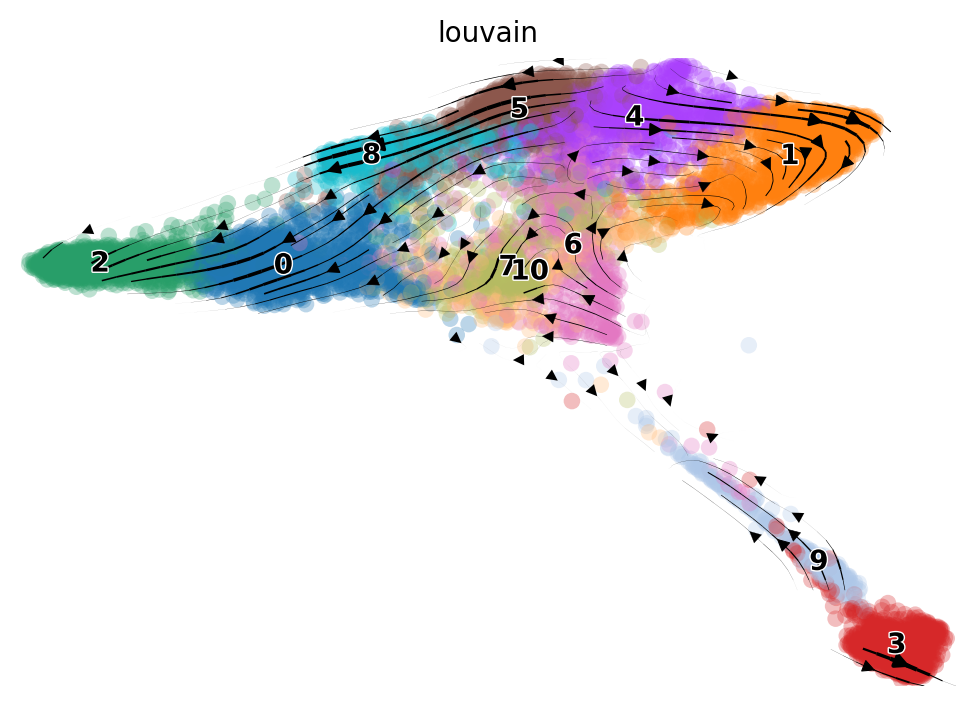

In [25]:
scv.pl.velocity_embedding_stream(adata, basis='paga', color=['louvain'], dpi=100)

In [26]:
#scv.tl.recover_dynamics(adata)
#scv.tl.velocity(adata, mode='dynamical')
#scv.tl.velocity_graph(adata)

In [27]:
adata.write('%s_scVelo.h5ad'%sp_name, compression='gzip')
adata.write_csvs("scVelo")

writing .csv files to scVelo


-----

## Reload point & Additional Plotting

In [37]:
adata = scv.read('%s_scVelo.h5ad'%sp_name)

saving figure to file ./figures/scvelo_Irf4.png


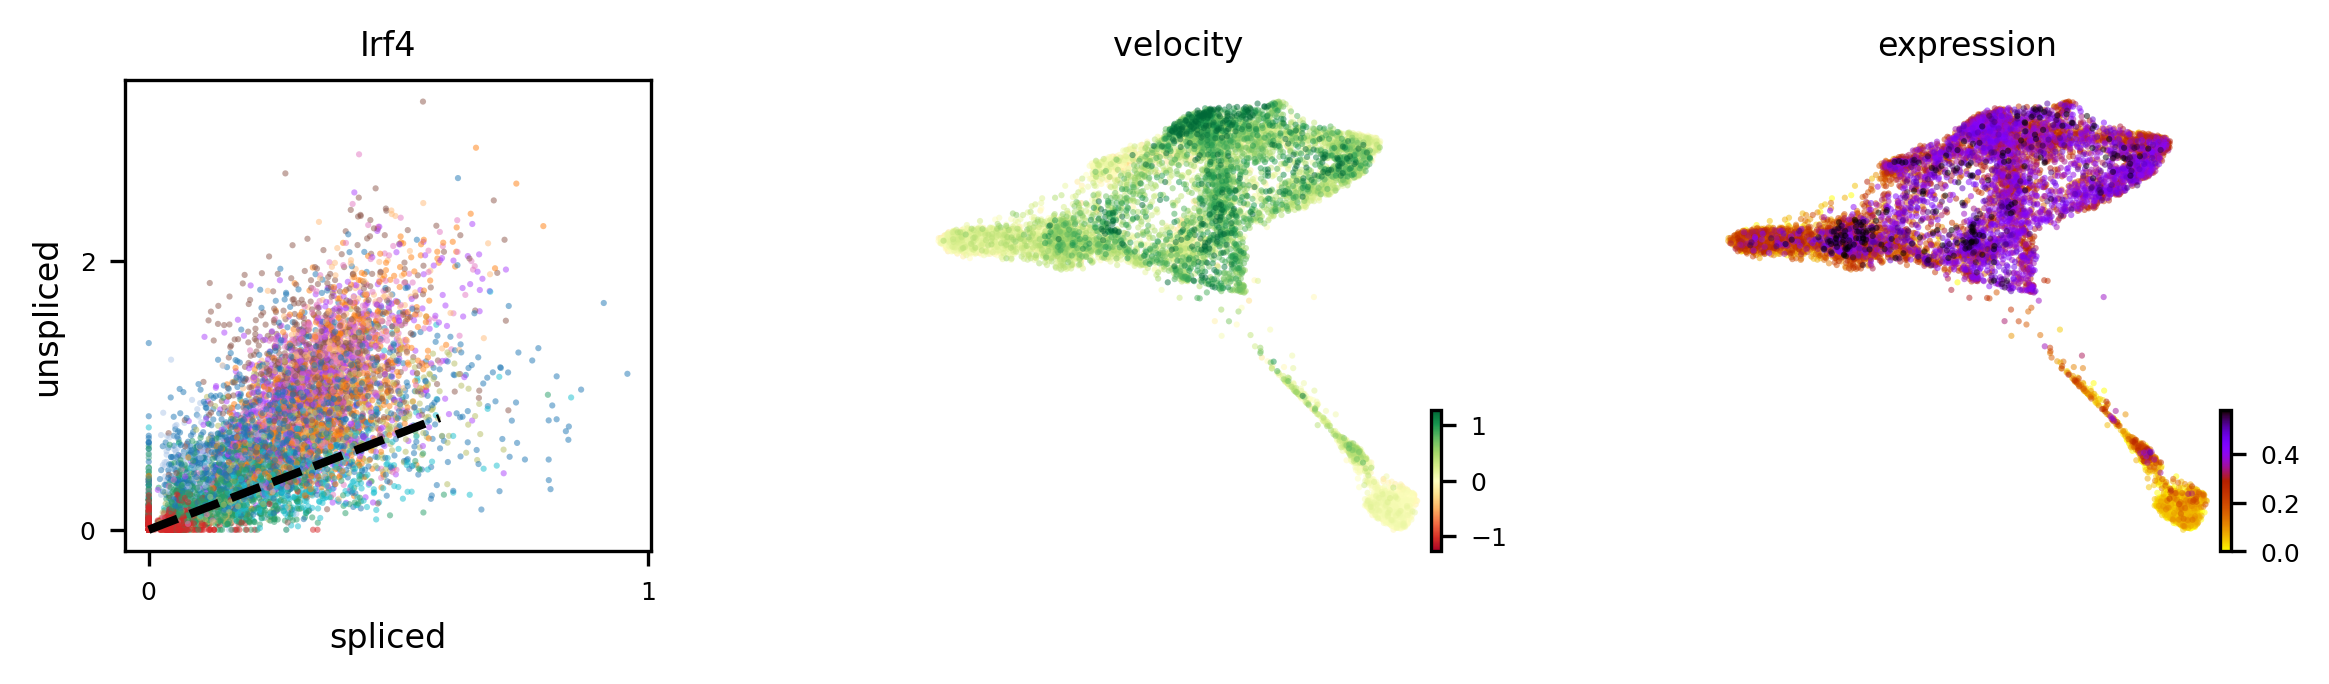

saving figure to file ./figures/scvelo_Prdm15.png


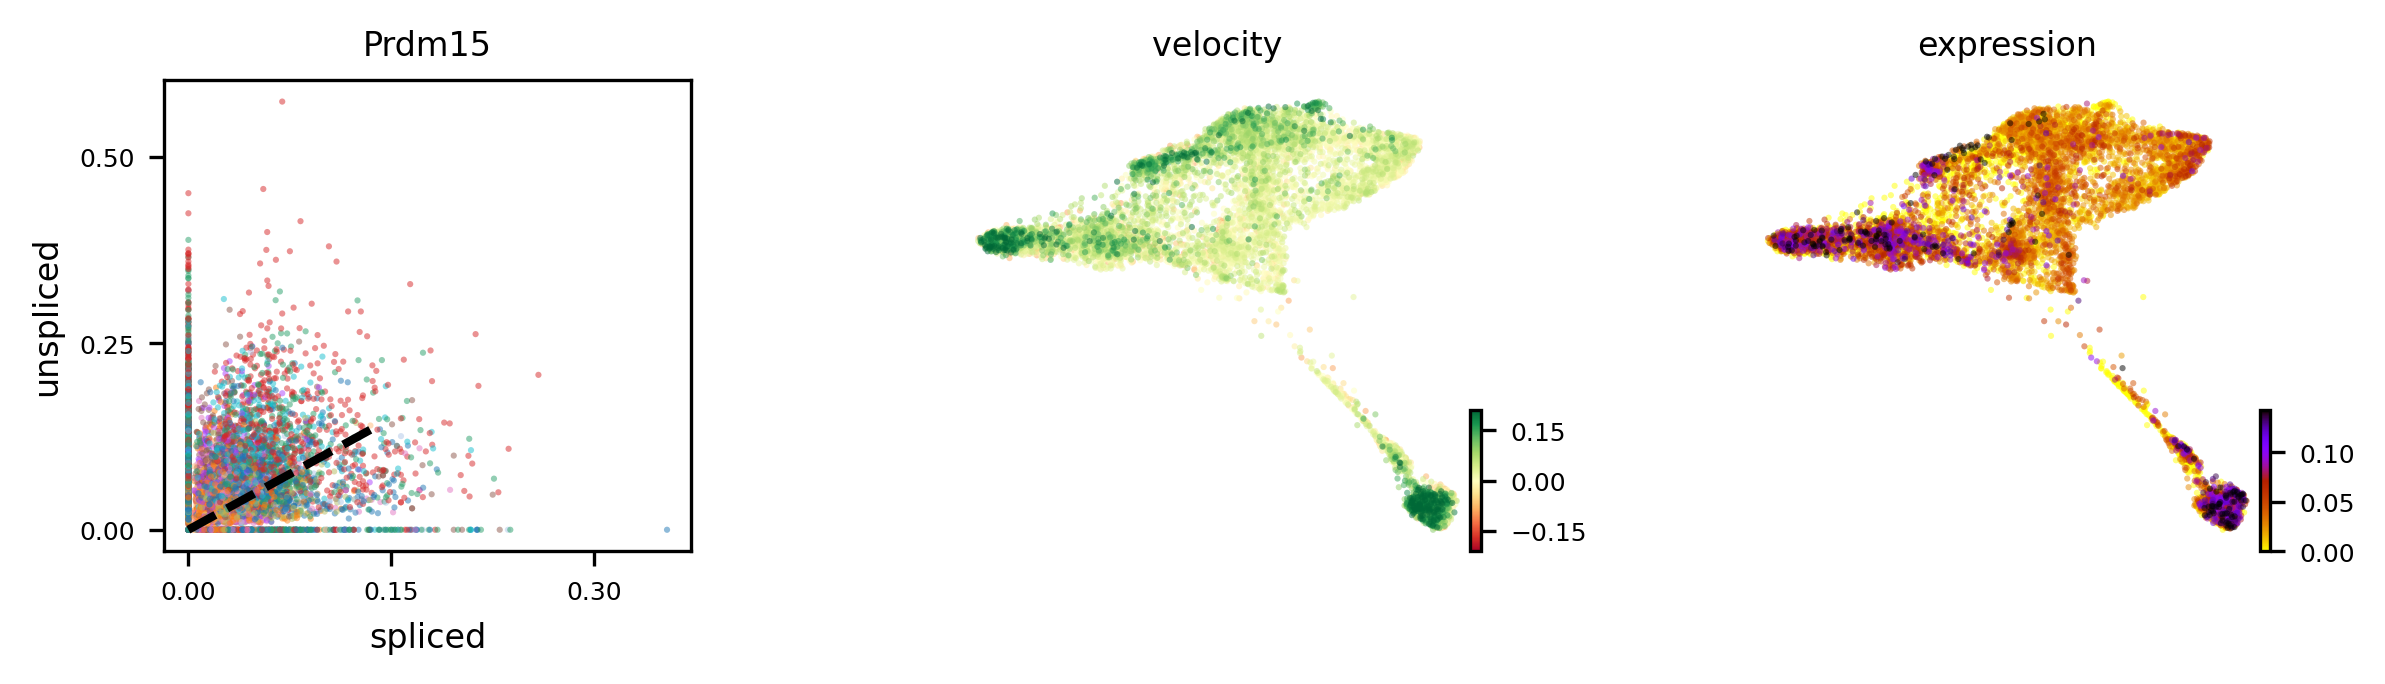

saving figure to file ./figures/scvelo_Fli1.png


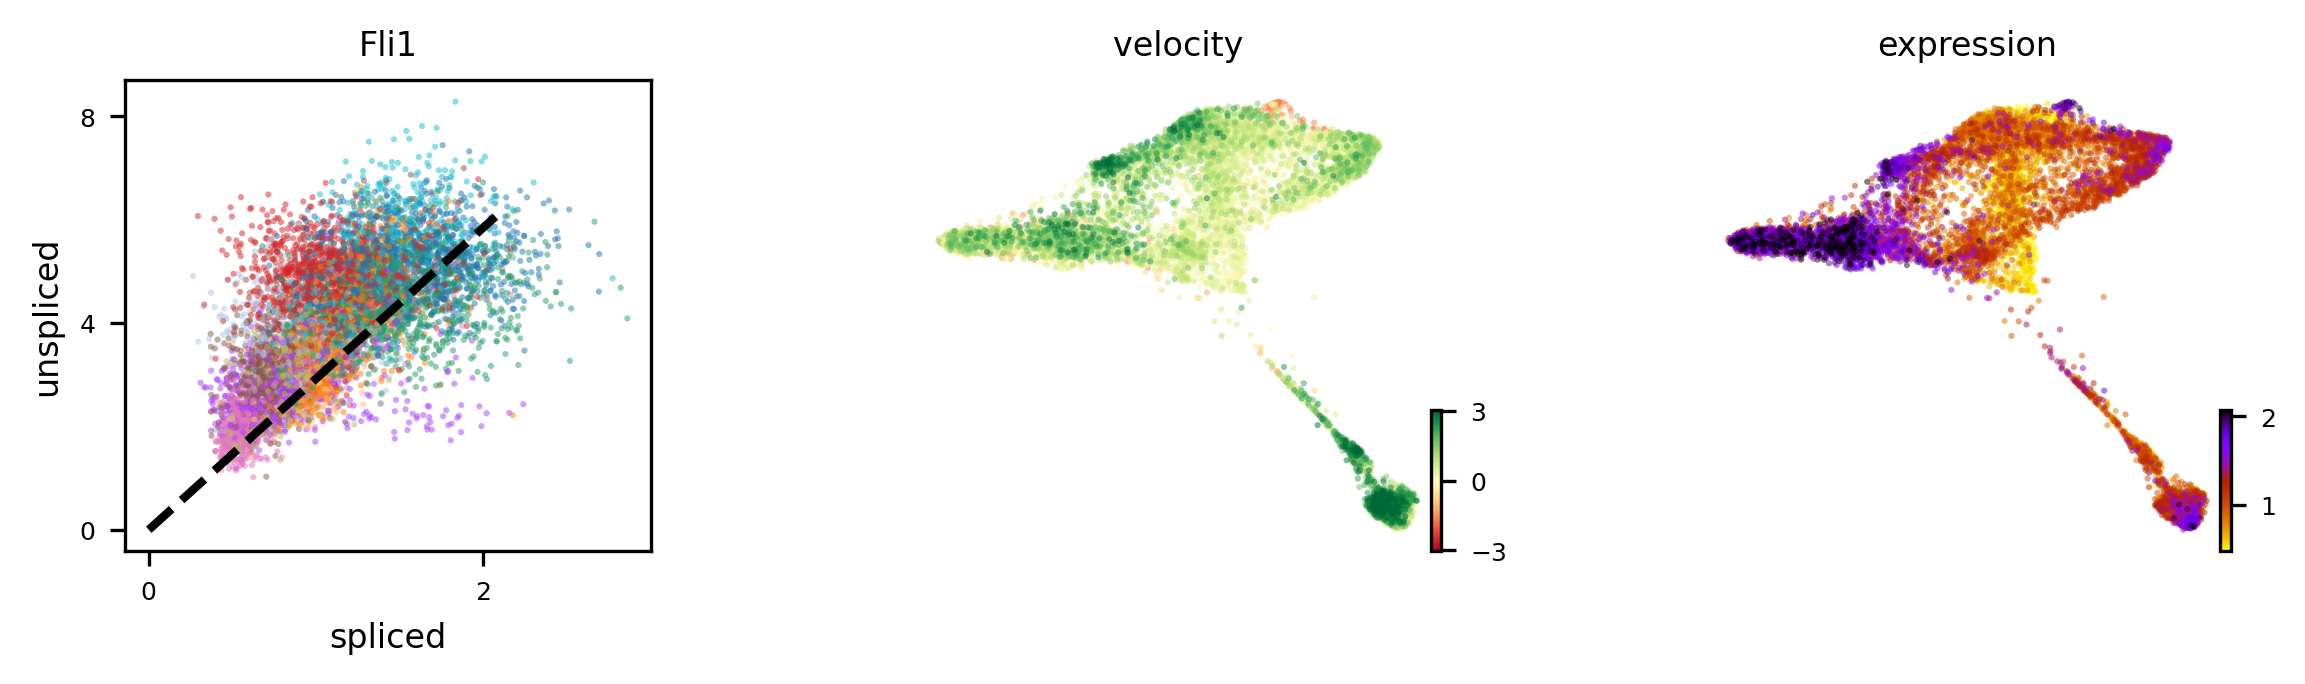

saving figure to file ./figures/scvelo_Tbx21.png


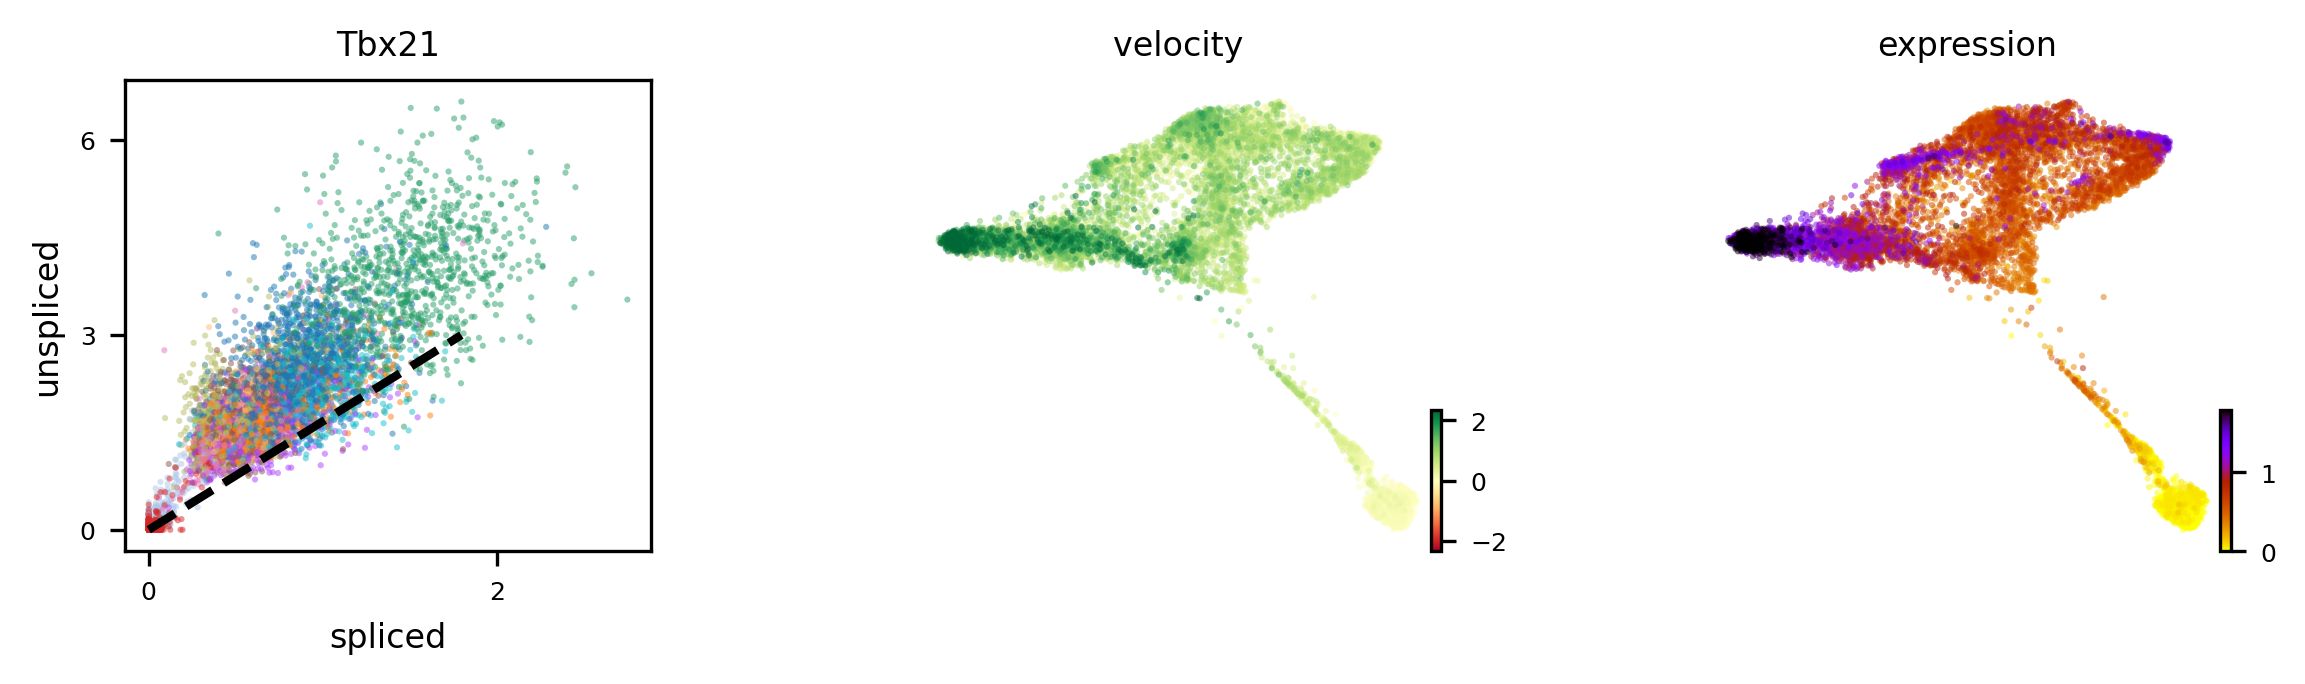

saving figure to file ./figures/scvelo_Runx3.png


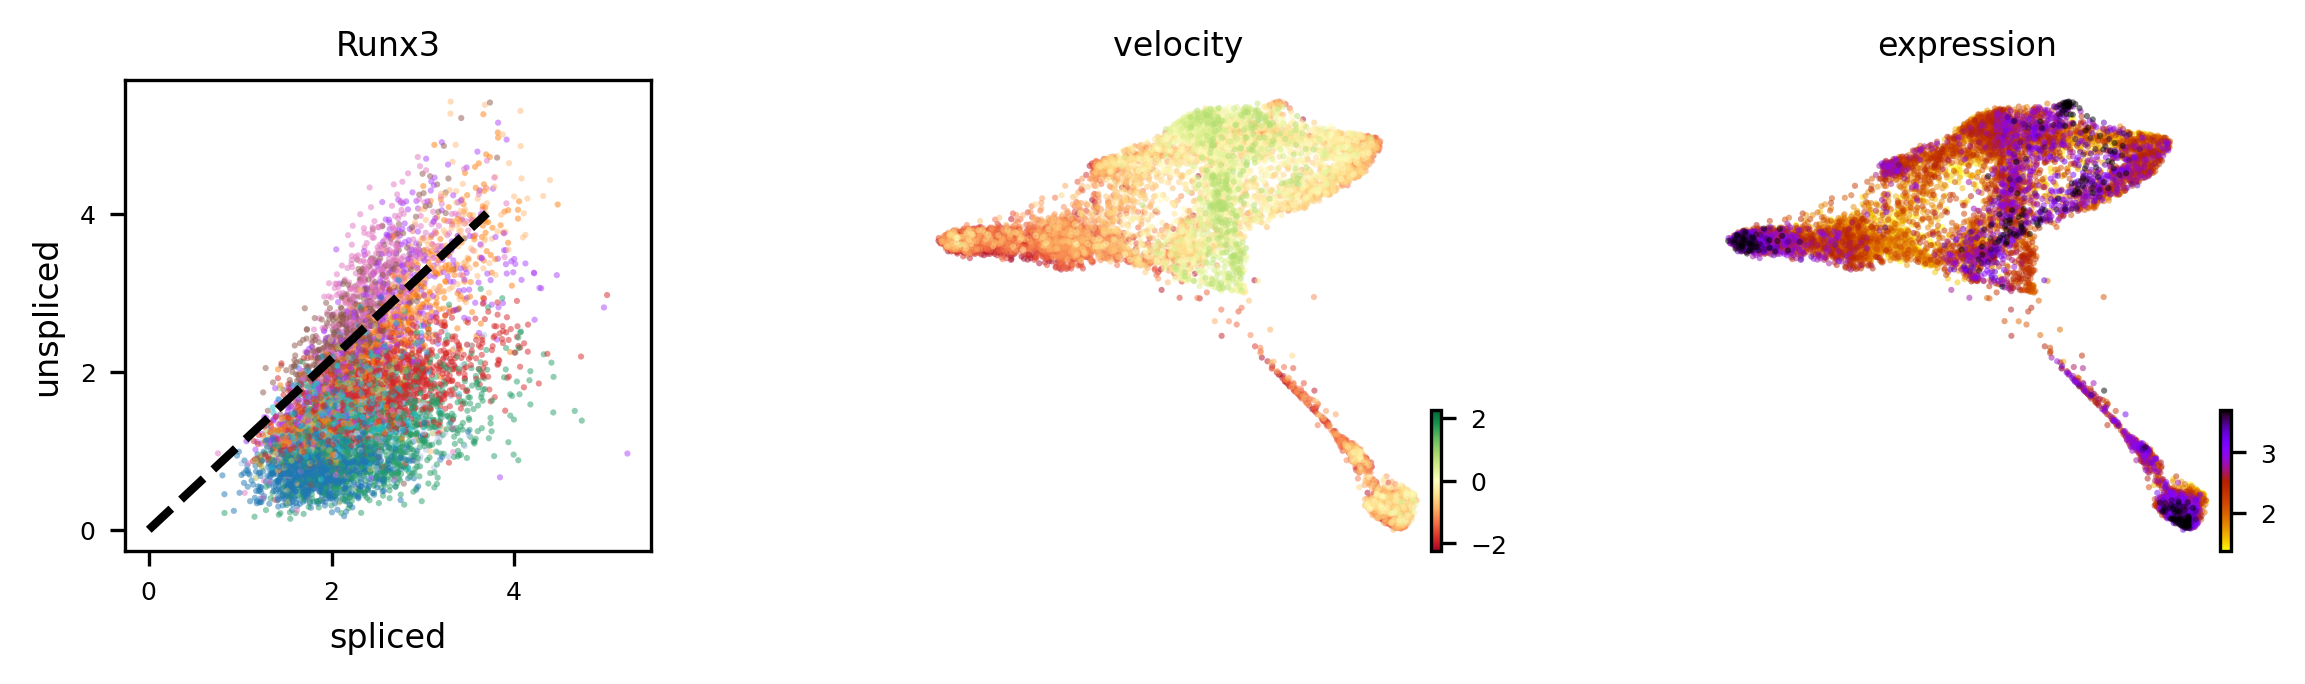

saving figure to file ./figures/scvelo_Tox.png


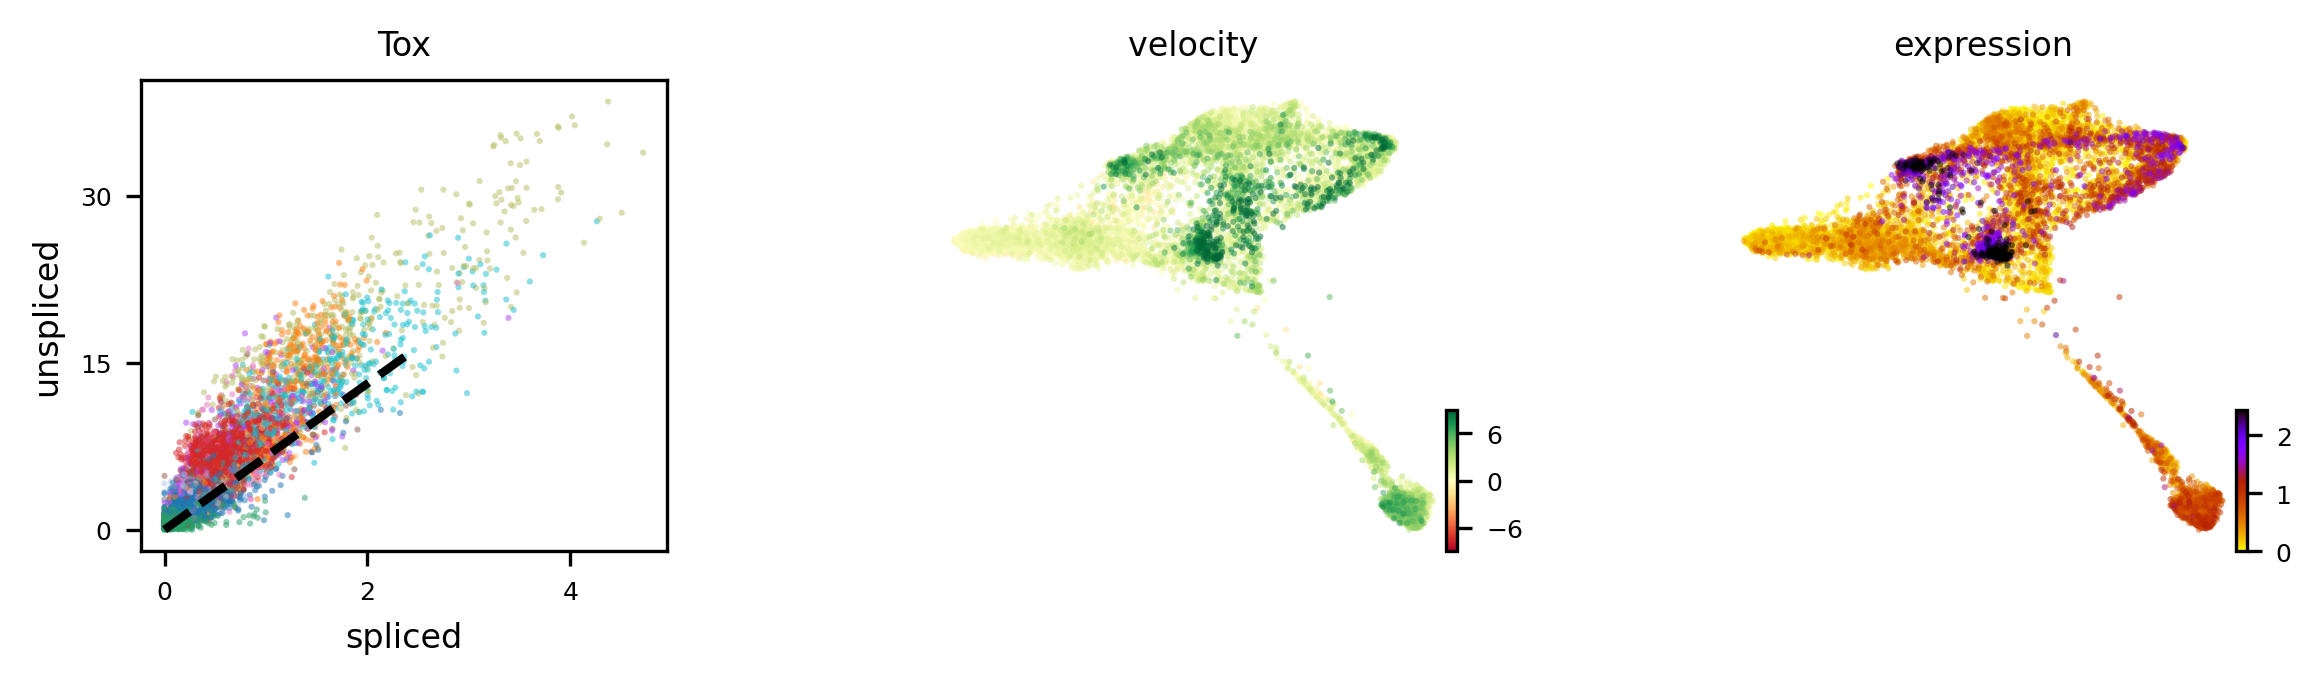

saving figure to file ./figures/scvelo_Tcf7.png


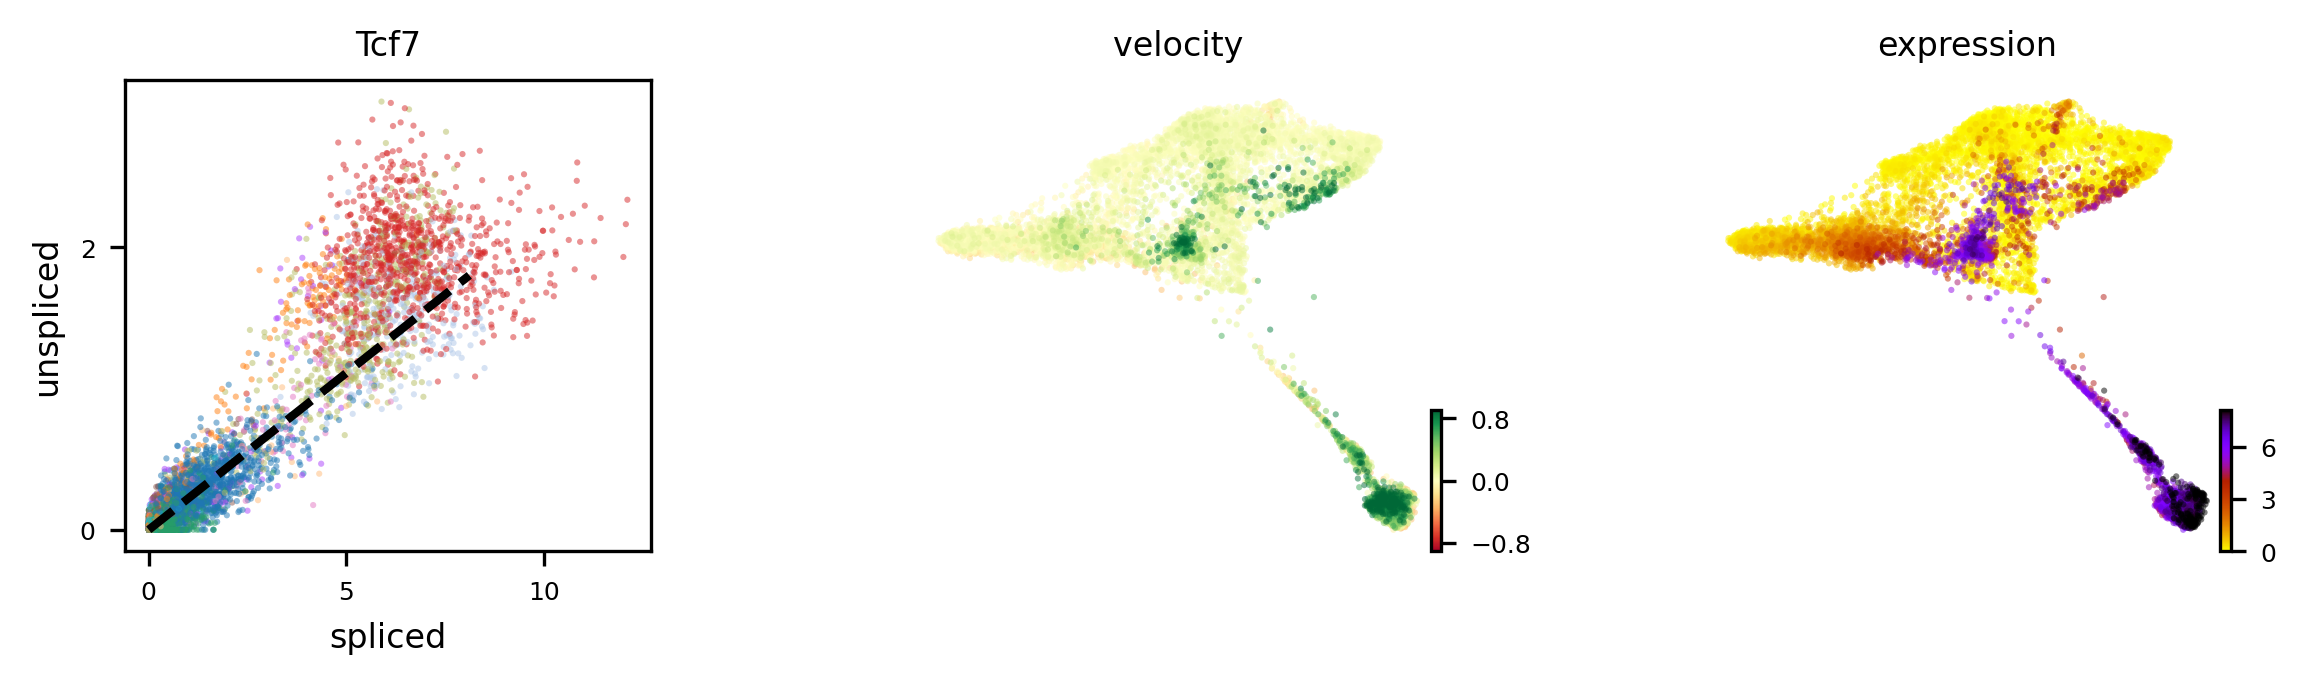

saving figure to file ./figures/scvelo_Id2.png


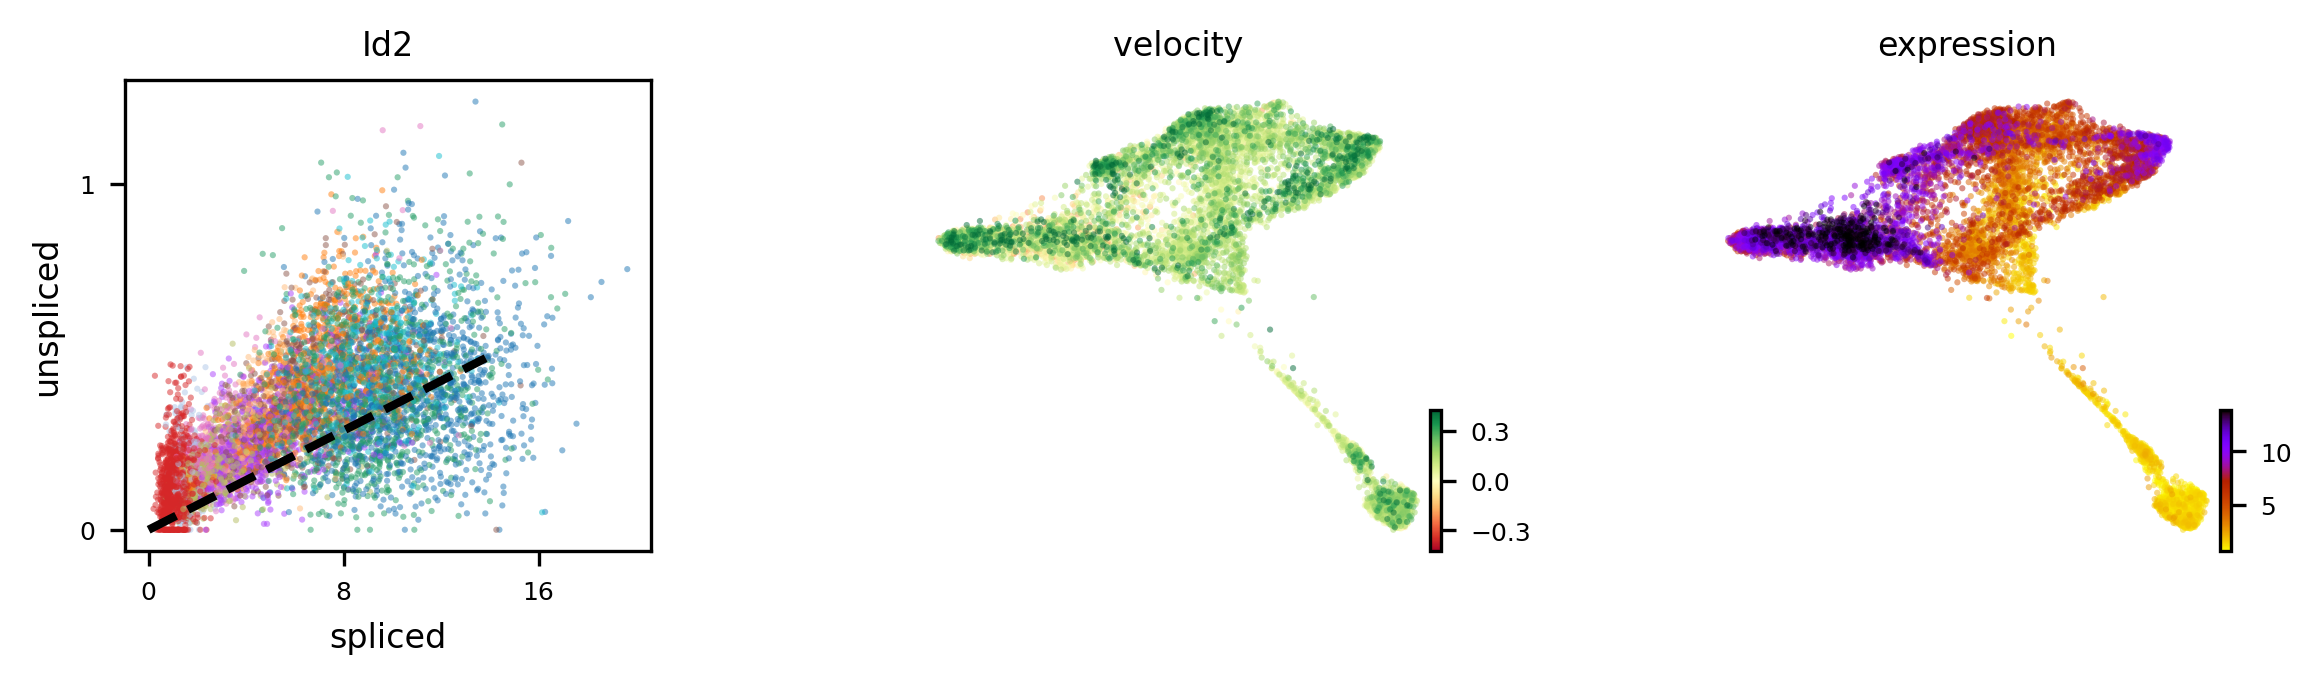

saving figure to file ./figures/scvelo_Bcl6.png


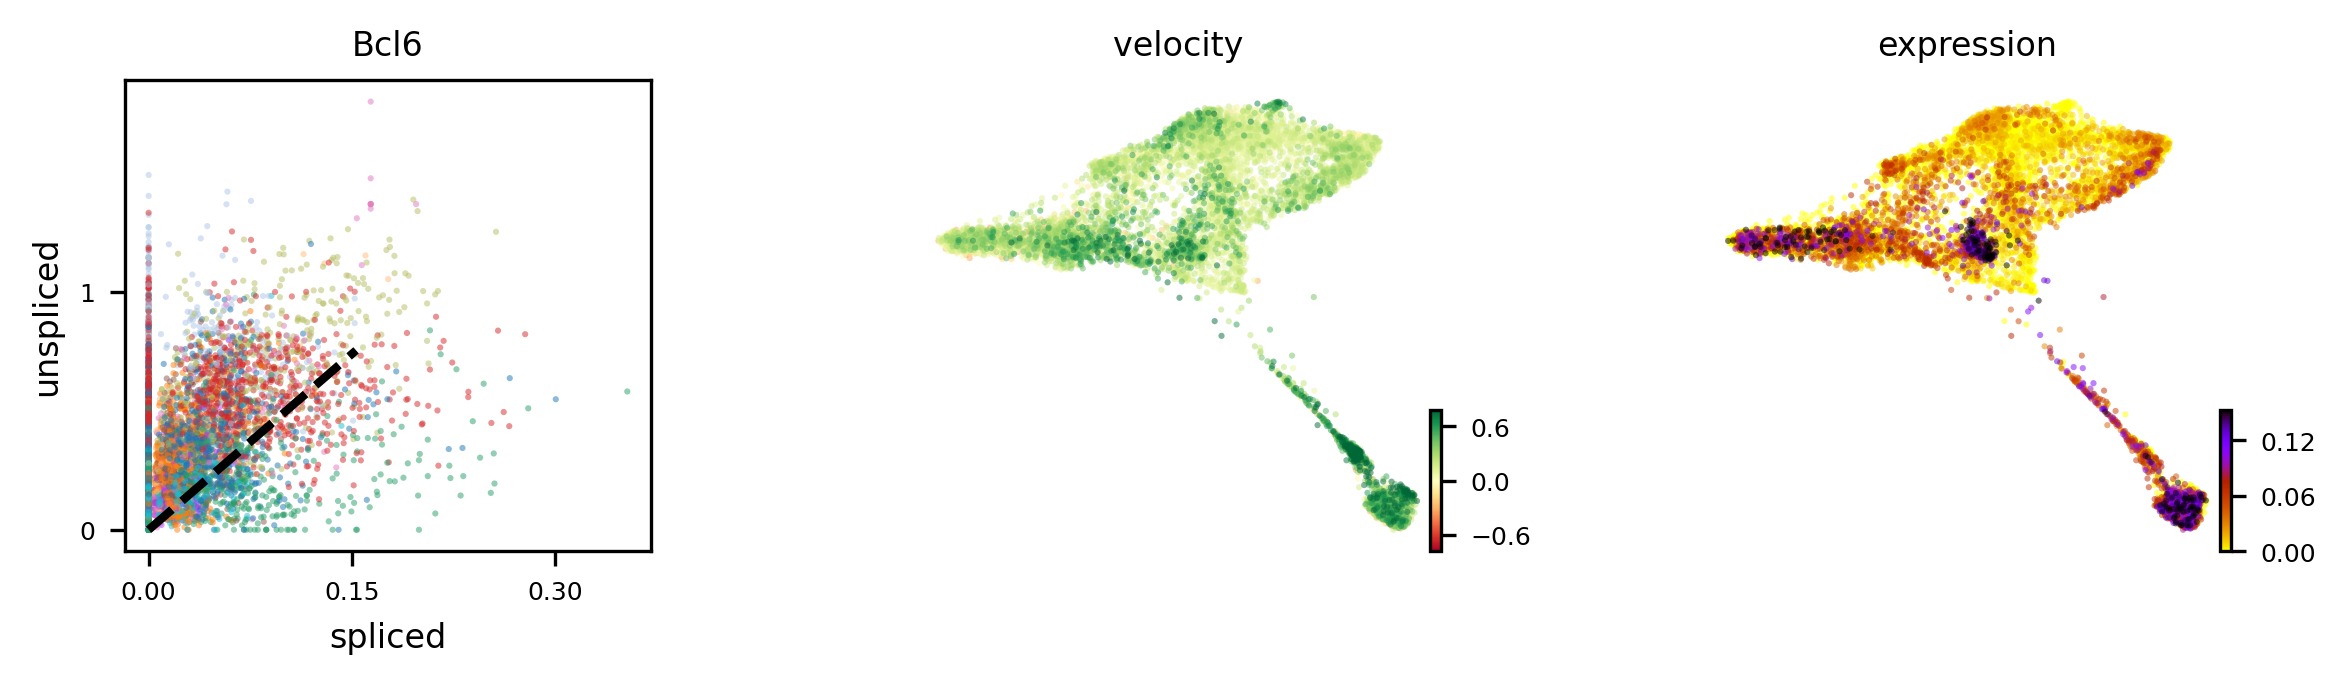

saving figure to file ./figures/scvelo_Il2ra.png


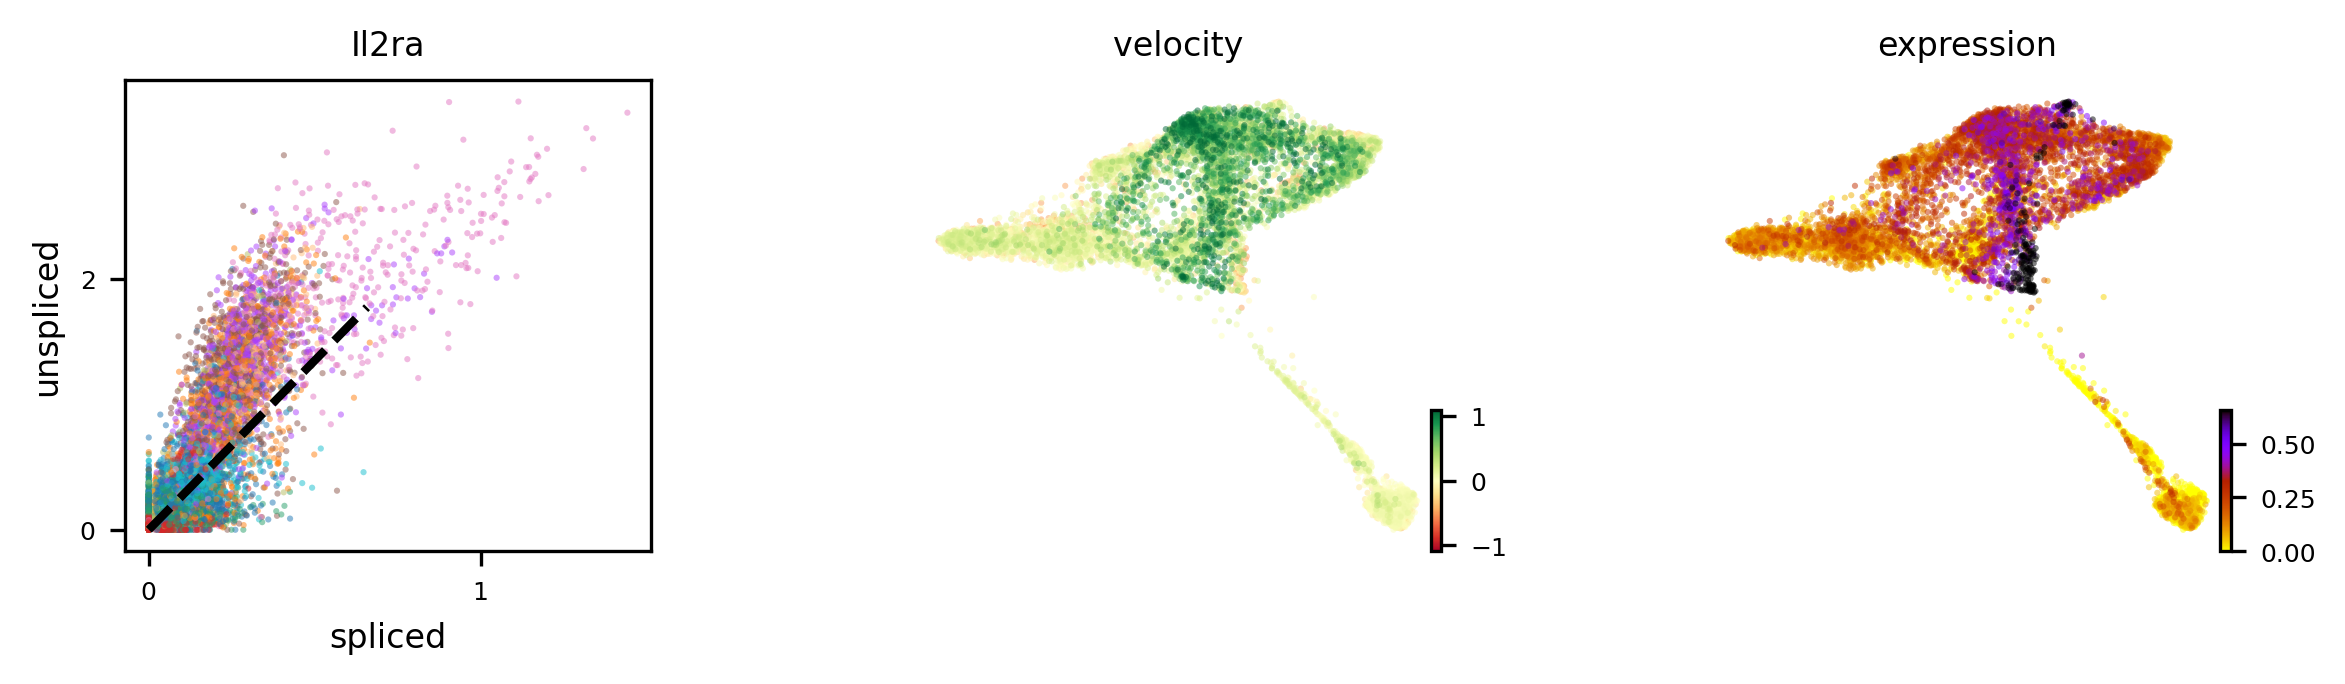

saving figure to file ./figures/scvelo_Kmt2a.png


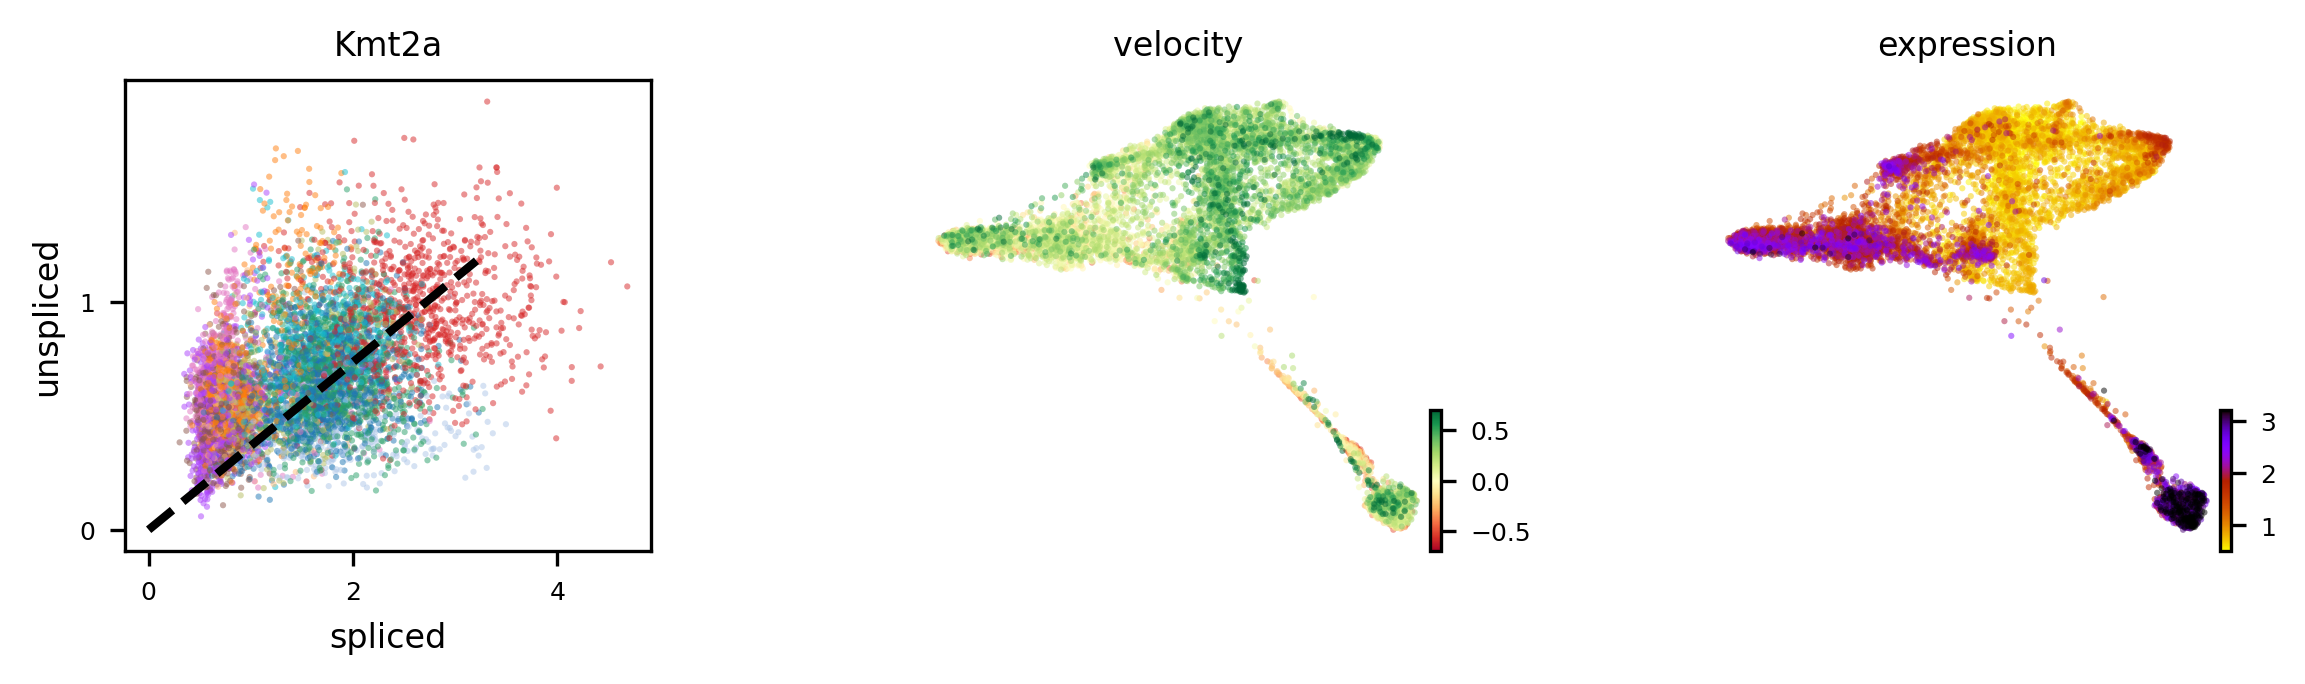

saving figure to file ./figures/scvelo_Smarca4.png


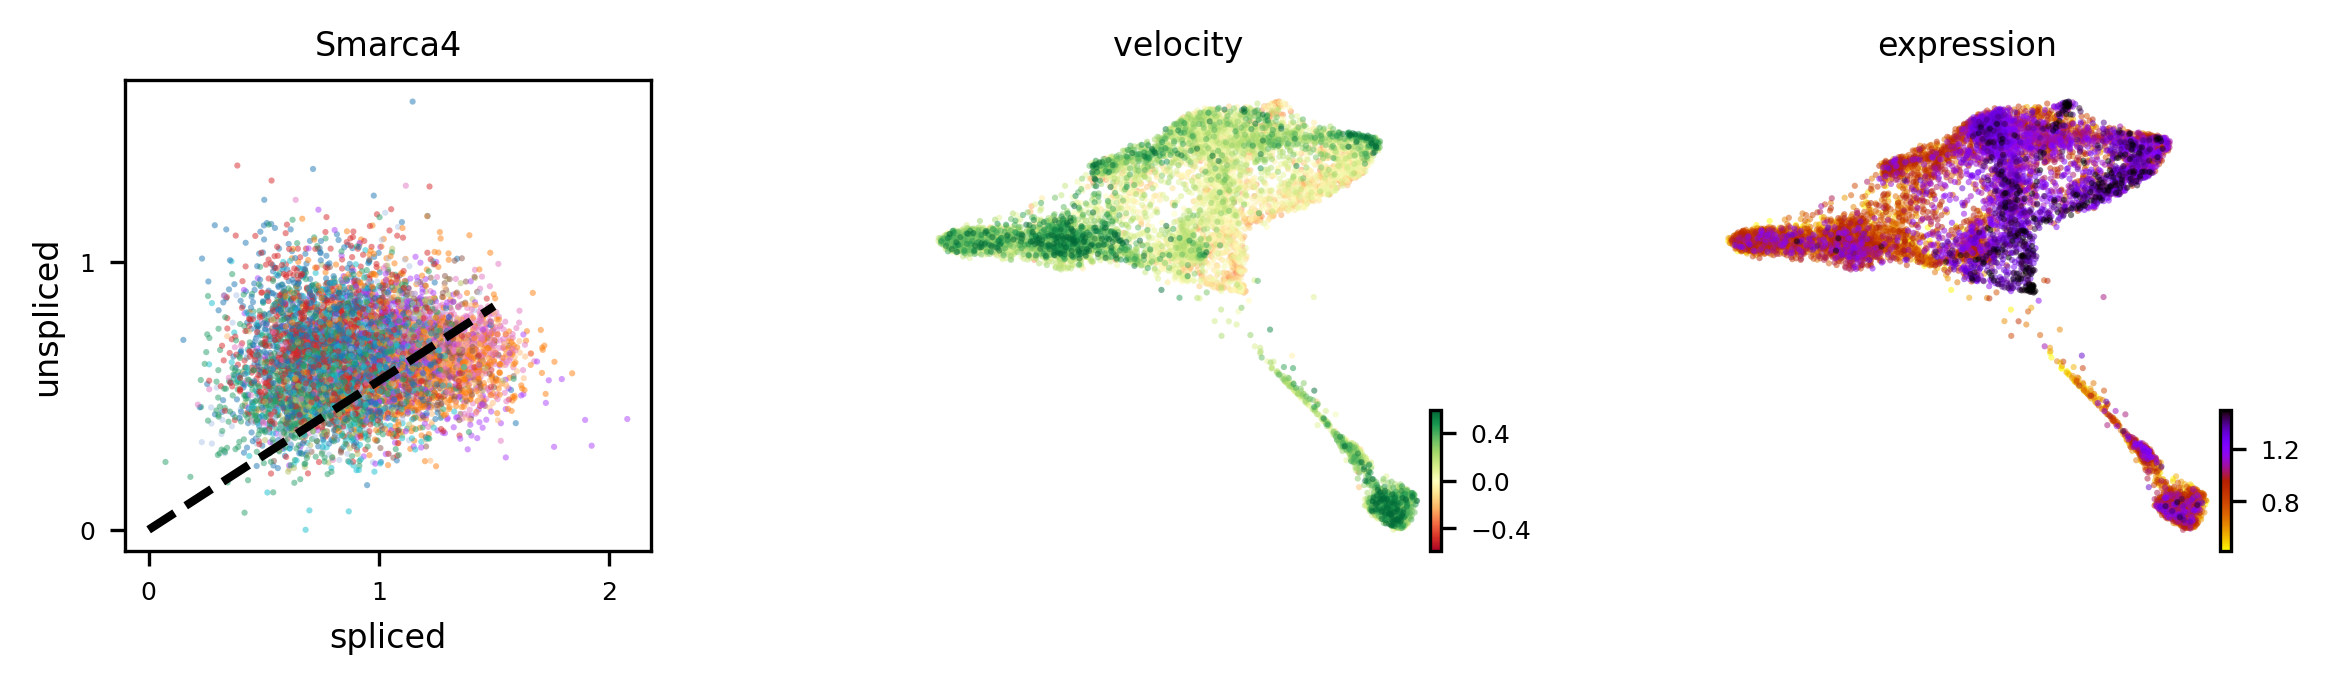

In [38]:
gnames = ['Irf4', 'Prdm15', 'Fli1', 'Tbx21', 'Runx3', 'Tox', 'Tcf7', 'Id2',  'Bcl6', 'Il2ra', 'Kmt2a', 'Smarca4']
for gname in gnames:
    kwargs = dict(linewidth=2, add_linfit=True)
    scv.pl.velocity(adata, gname, add_outline='fit_diff_kinetics', basis='paga',**kwargs, dpi=150, save="%s.png"%gname)

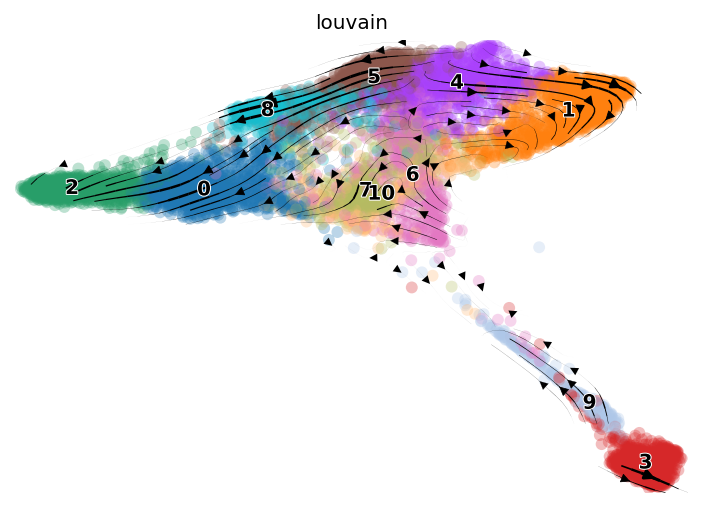

In [39]:
scv.pl.velocity_embedding_stream(adata, basis='paga')

## Terminal status analysis

computing terminal states
    identified 0 region of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
saving figure to file ./figures/scvelo_root_end.png


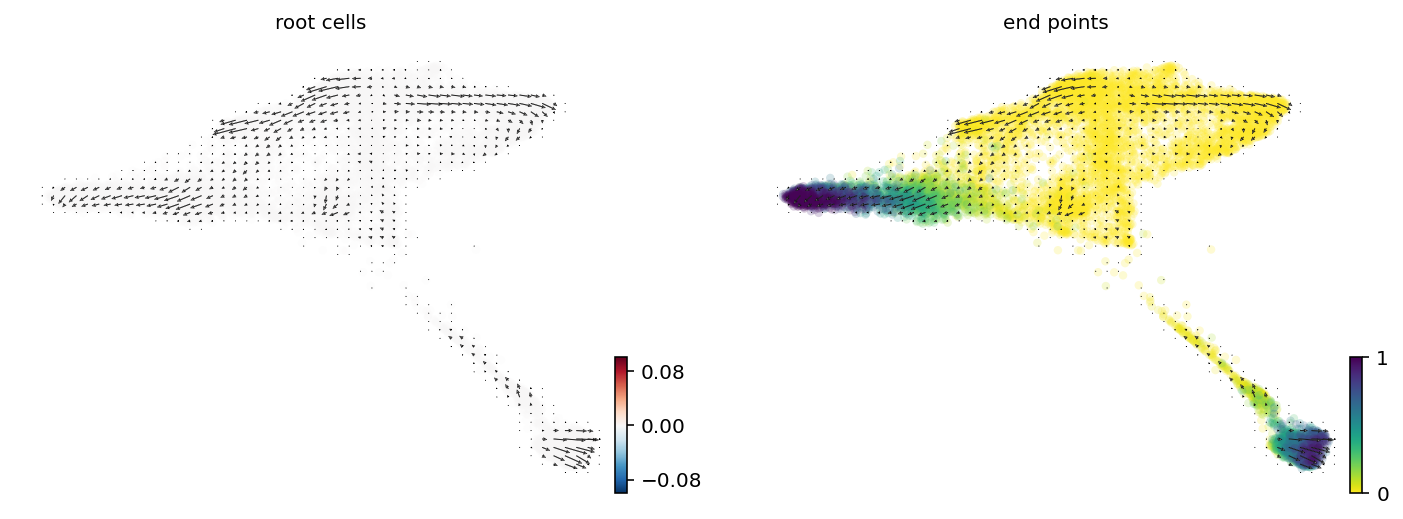

In [40]:
scv.tl.terminal_states(adata)
scv.pl.velocity_embedding_grid(adata, basis='paga', color=['root_cells', 'end_points'], save="root_end.png")

computing terminal states
    identified 0 region of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


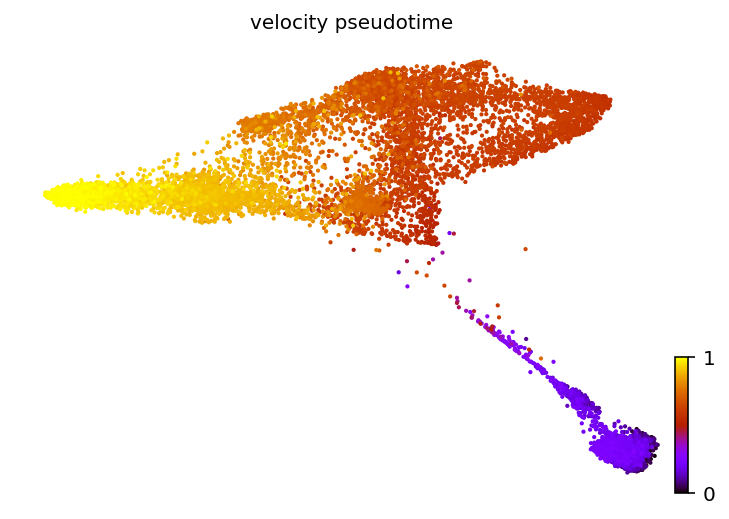

In [41]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata,  basis='paga', color='velocity_pseudotime', cmap='gnuplot')
#scv.tl.latent_time(adata)
#scv.pl.scatter(adata, color='latent_time', basis='paga', color_map='gnuplot', size=80, colorbar=True)

In [42]:
avg_df = adata.obs.groupby('louvain').mean().sort_values('velocity_pseudotime')
avg_df['louvain_new_label'] = ["P%s"%x for x in range(0, len(avg_df))]
avg_df.to_csv("pt_ordered_cluster_avg.csv")

In [43]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='louvain')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


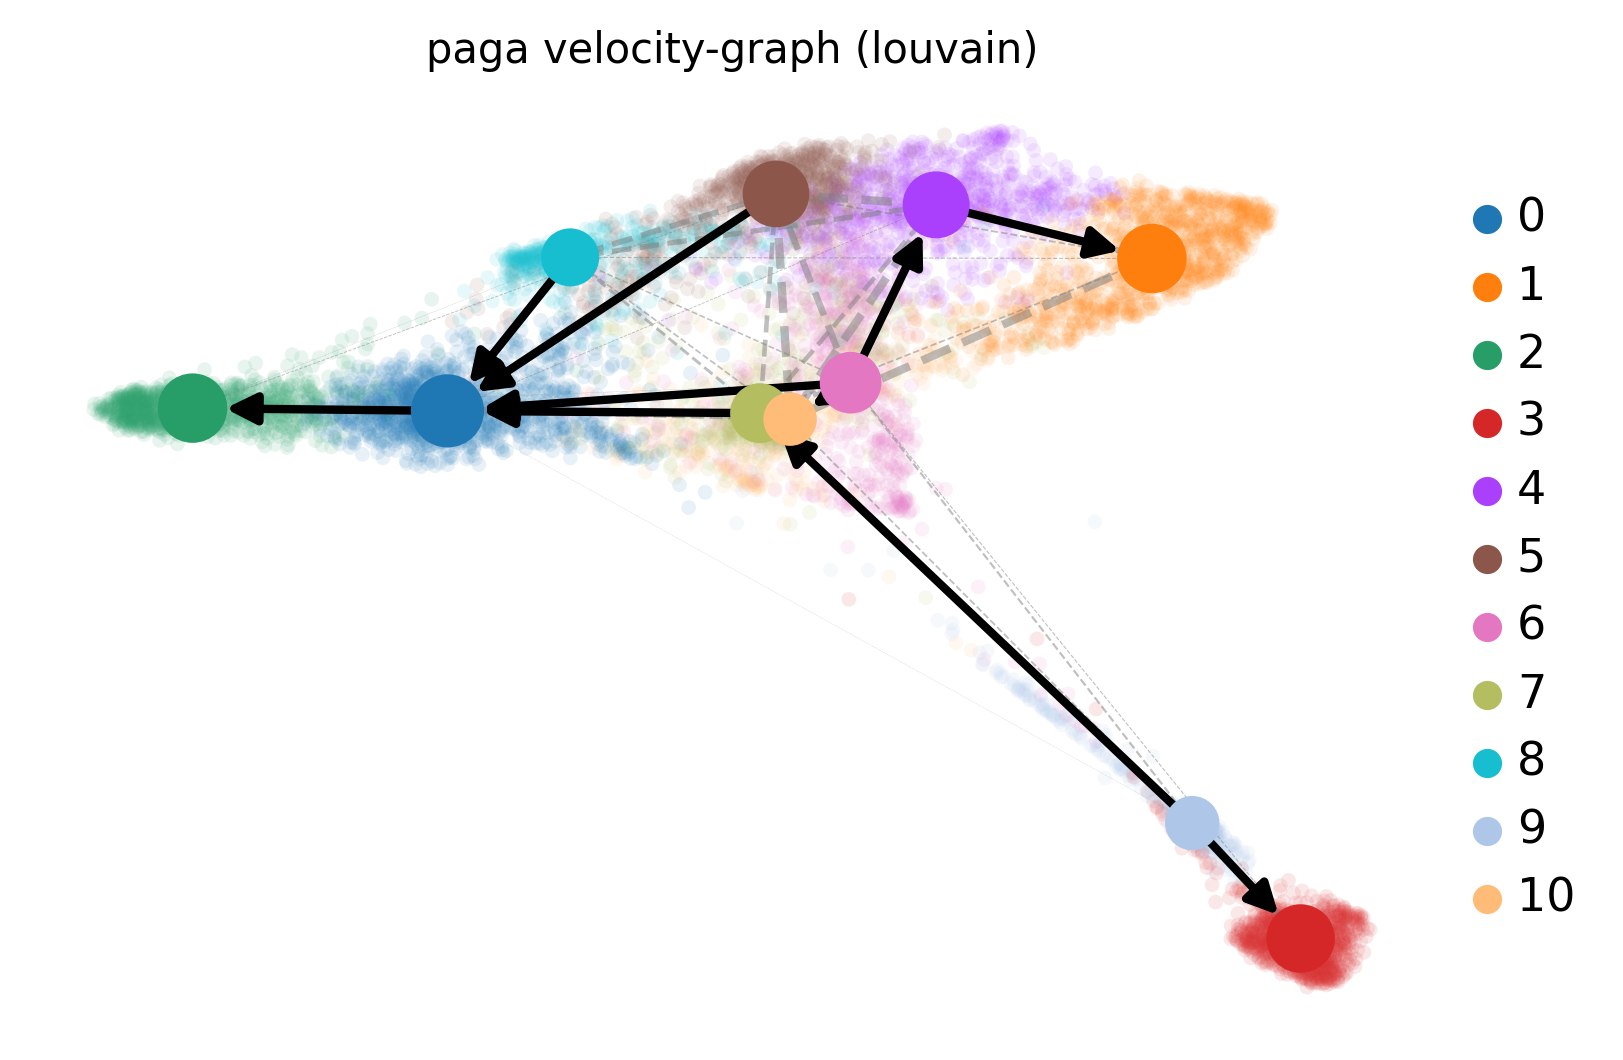

In [44]:
scv.pl.paga(adata, basis='paga', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5, dpi=150)

## Save

In [45]:
adata.write('%s_scVelo_postPT.h5ad'%sp_name, compression='gzip')
adata.write_csvs("scVelo")

writing .csv files to scVelo
